# Recommending System by Clustering of Canada Province Data

#### Install the required libraries

In [1]:
#Install Libraries
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0
!conda install -c conda-forge wikipedia

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

#### Import required libraries

In [2]:
#Setting Environment and importing libraries

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import pandas as pd # library to handle data in DataFrame
import folium # map rendering library
import numpy as np # library to handle data in a vectorized manner
import wikipedia as wp # library to handle data from Wikipedia
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Libraries installed and imported.')

Libraries installed and imported.


#### Fetch Data from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and manipulate data to create DataFrame

In [3]:
#Create DataFrame from Wikipedia
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]

In [4]:
#Drop the entries with Unassigned Borough
tor_df = df.drop(df[df['Borough'] == 'Not assigned'].index) 
tor_df.Neighbourhood.replace("Not assigned", tor_df.Borough,inplace = True)

In [5]:
#Grouping DataFrame by Post Code and Borough and renaming the columns 
tor_df = tor_df.groupby(['Postcode','Borough']).Neighbourhood.agg([('Neighbourhood', ', '.join)]).reset_index().rename(columns={'Postcode':'PostalCode'})

In [6]:
tor_df.rename(columns={'Neighbourhood':'Neighborhood'},inplace = True)
tor_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
#Shape of the Final DataFrame
tor_df.shape

(103, 3)

#### Read Geospatial_Coordinates.csv to get coordinates of Neighborhood

In [8]:
# The code was removed by Watson Studio for sharing.

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# Join tor_df and geo_df to get the final DataFrame
toronto_df = tor_df.join(geo_df.set_index('PostalCode'), on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Use geopy library to get the latitude and longitude values of Toronto

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>toronto_explorer</em>, as shown below.

In [10]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, PostalCode in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['PostalCode']):
    label = '{}, {}'.format(PostalCode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'CUVERS5NZA2PGO04OFER1SDYGPYM12XERC53PEZQ2ISSBWTJ' # your Foursquare ID
CLIENT_SECRET = 'MI3YCOHLGEG1LZSESYPSV3UBCFCQFWAHC0W0HTPW00NBROW1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CUVERS5NZA2PGO04OFER1SDYGPYM12XERC53PEZQ2ISSBWTJ
CLIENT_SECRET:MI3YCOHLGEG1LZSESYPSV3UBCFCQFWAHC0W0HTPW00NBROW1


#### Let's create a function to get top 100 venues the neighborhoods in Toronto

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [14]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

#### Let's check the size of the resulting dataframe

In [15]:
print(toronto_venues.shape)
toronto_venues.head()

(2244, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


Let's check how many venues were returned for each neighborhood

In [16]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,57,57,57,57,57,57


#### Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 280 uniques categories.


#### Below are the concerned Venue category
1. Park
2. Gym
3. Gym / Fitness Center
4. Sporting Goods Shop
5. Yoga Studio
6. Playground
7. Trail
8. Baseball Field
9. Athletics & Sports
10. Pool
11. Basketball Stadium
12. Hockey Arena
13. Baseball Stadium
14. Skate Park
15. Soccer Field
16. Stadium

### Analyze Each Neighborhood

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2244, 281)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women'

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [19]:
toronto_grouped = toronto_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(101, 281)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women'

#### Create new dataframe for recreational event categories

In [20]:
toronto_recr = toronto_grouped[["Neighborhoods","Park","Gym","Gym / Fitness Center","Yoga Studio","Playground","Trail","Baseball Field","Athletics & Sports","Pool","Basketball Stadium","Hockey Arena","Baseball Stadium","Skate Park","Soccer Field","Stadium"]]
toronto_recr.head()

,Neighborhoods,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium
0,"Adelaide, King, Richmond",0.0,0.030000,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.5,0.000000,0.00,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.111111,0.00,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


### Cluster Neighborhoods
##### Run k-means to cluster the neighborhoods in Toronto into 3 clusters.

In [21]:
# set number of clusters
torontoclusters = 3

toronto_clustering = toronto_recr.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=torontoclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [22]:
# create a new dataframe that includes the cluster 
toronto_merged = toronto_recr.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

toronto_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
toronto_merged.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels
0,"Adelaide, King, Richmond",0.0,0.030000,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Agincourt,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.5,0.000000,0.00,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"Alderwood, Long Branch",0.0,0.111111,0.00,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0


In [23]:
toronto_df.head()
toronto_lookup = toronto_df.drop(['PostalCode', 'Borough'], axis=1)
toronto_lookup.head()

,Neighborhood,Latitude,Longitude
0,"Rouge, Malvern",43.806686,-79.194353
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Woburn,43.770992,-79.216917
4,Cedarbrae,43.773136,-79.239476


In [24]:
# merge toronto_grouped with toronto_lookup to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_lookup.set_index("Neighborhood"), on="Neighborhood")
toronto_merged.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude
0,"Adelaide, King, Richmond",0.0,0.030000,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,43.650571,-79.384568
1,Agincourt,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.5,0.000000,0.00,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,43.815252,-79.284577
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,43.739416,-79.588437
4,"Alderwood, Long Branch",0.0,0.111111,0.00,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0,43.602414,-79.543484


In [25]:
# sort the results by Cluster Labels
toronto_merged = toronto_merged.sort_values(["Cluster Labels"]).reset_index(drop = True)
toronto_merged

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude
0,"Adelaide, King, Richmond",0.000000,0.030000,0.010000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.650571,-79.384568
1,"Northwood Park, York University",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.767980,-79.487262
2,Northwest,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.706748,-79.594054
3,North Toronto West,0.050000,0.000000,0.000000,0.050000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.715383,-79.405678
4,"Maryvale, Wexford",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.750072,-79.295849
5,"Little Portugal, Trinity",0.015385,0.000000,0.015385,0.015385,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.647927,-79.419750
6,Leaside,0.000000,0.029412,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.709060,-79.363452
7,"Lawrence Heights, Lawrence Manor",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.718518,-79.464763
8,L'Amoreaux West,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.799525,-79.318389
9,"Kingsway Park South West, Mimico NW, The Queen...",0.000000,0.066667,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0,43.628841,-79.520999


In [26]:
#Group the data by Cluster Labels 
toronto_clus_report = toronto_merged.groupby(["Cluster Labels"]).sum().reset_index()
toronto_clus_report

,Cluster Labels,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Latitude,Longitude
0,0,1.303563,1.006217,0.870288,0.307348,0.355556,0.47381,0.600282,0.650433,0.527778,0.047961,0.5,0.02,0.052632,0.111111,0.047619,3714.566386,-6748.326755
1,1,6.366667,0.250000,0.000000,0.000000,0.950000,0.45000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,655.779464,-1191.309874
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,43.724766,-79.532242


In [27]:
#Transpose the data frame for plotting chart on the data 
toronto_clus_pivot = toronto_clus_report.transpose()
toronto_clus_pivot.drop(['Cluster Labels', 'Latitude','Longitude'],inplace = True)
toronto_clus_pivot

,0,1,2
Park,1.303563,6.366667,0.0
Gym,1.006217,0.250000,0.0
Gym / Fitness Center,0.870288,0.000000,0.0
Yoga Studio,0.307348,0.000000,0.0
Playground,0.355556,0.950000,0.0
Trail,0.473810,0.450000,0.0
Baseball Field,0.600282,0.000000,1.0
Athletics & Sports,0.650433,0.000000,0.0
Pool,0.527778,0.000000,0.0
Basketball Stadium,0.047961,0.000000,0.0


In [28]:
toronto_clus_pivot.describe()

,0,1,2
count,15.000000,15.000000,15.000000
mean,0.458306,0.534444,0.066667
std,0.386919,1.634832,0.258199
min,0.020000,0.000000,0.000000
25%,0.081871,0.000000,0.000000
50%,0.473810,0.000000,0.000000
75%,0.625358,0.125000,0.000000
max,1.303563,6.366667,1.000000


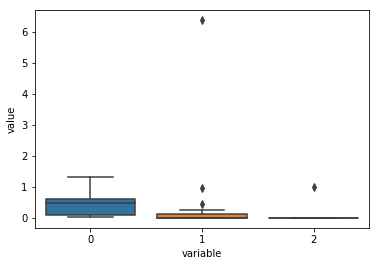

In [29]:
#Chart boxplot on all clusters
sns.boxplot(x="variable", y="value", data=pd.melt(toronto_clus_pivot))
plt.show()

Among all clusters cluster 0 has maximum occurances of venue which are related to Sporting Goods. Hence, this analysis can recommend the user to open the store in one of locations in Cluster 0. Below image shows the clusters in the map of Toronto. 

#### Visualize the clusters

In [30]:
kclusters = 3
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

#### Deep Dive for precise recommendation
Now that we have come to a point where we can recommend that Cluter 0 is safer to open a Sporting Goods store in a broad way, lets deep dive to the data to find out which neighborhoods are the best for the opportunity.
Below analysis will give a result of top 5 neighborhoods based on maximum types and maximum number of sporting venues. 

In [31]:
#Add Count of non zero occurance and sum of sporting venues in the dataframe
toronto_sc = toronto_merged
col_list= list(toronto_merged)
col_list.remove('Neighborhood')
col_list.remove('Cluster Labels')
col_list.remove('Latitude')
col_list.remove('Longitude')
col_list
toronto_sc['Sum'] = toronto_merged[col_list].sum(axis=1)
toronto_sc['Count'] = toronto_merged[col_list].gt(0).sum(axis=1)
toronto_sc.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude,Sum,Count
0,"Adelaide, King, Richmond",0.00,0.03,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.650571,-79.384568,0.04,2
1,"Northwood Park, York University",0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.767980,-79.487262,0.00,0
2,Northwest,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.706748,-79.594054,0.00,0
3,North Toronto West,0.05,0.00,0.00,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.715383,-79.405678,0.10,2
4,"Maryvale, Wexford",0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.750072,-79.295849,0.00,0


In [32]:
#Sort the dataframe 
toronto_sort = toronto_sc.sort_values(["Count","Sum"],ascending = False).reset_index(drop = True)
toronto_sort.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude,Sum,Count
0,Business Reply Mail Processing Centre 969 Eastern,0.052632,0.0000,0.052632,0.052632,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0,43.662744,-79.321558,0.210526,4
1,Rosedale,0.400000,0.0000,0.000000,0.000000,0.20,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,43.679563,-79.377529,0.800000,3
2,"Moore Park, Summerhill East",0.250000,0.2500,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,43.689574,-79.383160,0.750000,3
3,Thorncliffe Park,0.062500,0.0625,0.000000,0.062500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,43.705369,-79.349372,0.187500,3
4,Queen's Park,0.050000,0.0500,0.000000,0.025000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,43.662301,-79.389494,0.125000,3


In [33]:
toronto_recom = toronto_sort.head()

In [34]:
#Join with neighborhood dataframe to plot the map
toronto_final = toronto_recom.join(toronto_df.set_index('Neighborhood'), on='Neighborhood',lsuffix='_a', rsuffix='_b')
toronto_final

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude_a,Longitude_a,Sum,Count,PostalCode,Borough,Latitude_b,Longitude_b
0,Business Reply Mail Processing Centre 969 Eastern,0.052632,0.0000,0.052632,0.052632,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0,43.662744,-79.321558,0.210526,4,M7Y,East Toronto,43.662744,-79.321558
1,Rosedale,0.400000,0.0000,0.000000,0.000000,0.20,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,43.679563,-79.377529,0.800000,3,M4W,Downtown Toronto,43.679563,-79.377529
2,"Moore Park, Summerhill East",0.250000,0.2500,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,43.689574,-79.383160,0.750000,3,M4T,Central Toronto,43.689574,-79.383160
3,Thorncliffe Park,0.062500,0.0625,0.000000,0.062500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,43.705369,-79.349372,0.187500,3,M4H,East York,43.705369,-79.349372
4,Queen's Park,0.050000,0.0500,0.000000,0.025000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,43.662301,-79.389494,0.125000,3,M7A,Queen's Park,43.662301,-79.389494


In [35]:
# create map of Toronto Neighborhood whiah are recommended to open a store
map_recom = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, PostalCode in zip(toronto_final['Latitude_a'], toronto_final['Longitude_a'], toronto_final['Borough'], toronto_final['PostalCode']):
    label = '{}, {}'.format(PostalCode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_recom)  
    
map_recom

**The top 5 recommended Neighborhoods to open Sporting Goods Store are**
1. Business Reply Mail Processing Centre 969 Eastern
2. Rosedale
3. Moore Park, Summerhill East
4. Thorncliffe Park
5. Queen's Park

**Lets find out the where the existing Sports Good Stores are located**

In [36]:
toronto_ss = toronto_grouped[["Neighborhoods","Sporting Goods Shop"]]
toronto_ss.head()

,Neighborhoods,Sporting Goods Shop
0,"Adelaide, King, Richmond",0.0
1,Agincourt,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0
4,"Alderwood, Long Branch",0.0


In [37]:
#Filter the dataframe where Sporting Goods Shop > 0
toronto_ssf = toronto_ss[toronto_ss['Sporting Goods Shop'] > 0].reset_index(drop = True)
toronto_ssf.columns = ['Neighborhood', 'Sporting Goods Shop']
toronto_ssf

,Neighborhood,Sporting Goods Shop
0,"Design Exchange, Toronto Dominion Centre",0.010000
1,"Fairview, Henry Farm, Oriole",0.016949
2,"Flemingdon Park, Don Mills South",0.050000
3,"Harbourfront East, Toronto Islands, Union Station",0.030000
4,Leaside,0.088235
5,North Toronto West,0.100000
6,"Ryerson, Garden District",0.010000


In [38]:
toronto_ssf = toronto_ssf.join(toronto_lookup.set_index("Neighborhood"), on="Neighborhood")
toronto_ssf

,Neighborhood,Sporting Goods Shop,Latitude,Longitude
0,"Design Exchange, Toronto Dominion Centre",0.010000,43.647177,-79.381576
1,"Fairview, Henry Farm, Oriole",0.016949,43.778517,-79.346556
2,"Flemingdon Park, Don Mills South",0.050000,43.725900,-79.340923
3,"Harbourfront East, Toronto Islands, Union Station",0.030000,43.640816,-79.381752
4,Leaside,0.088235,43.709060,-79.363452
5,North Toronto West,0.100000,43.715383,-79.405678
6,"Ryerson, Garden District",0.010000,43.657162,-79.378937


In [39]:
# create map of Toronto Neighborhood where Sporting Goods are present
map_store = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_ssf.Latitude, toronto_ssf.Longitude, toronto_ssf.Neighborhood):
    folium.features.CircleMarker(
        [lat, lng],
        radius=12,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_store)  
    
map_store

### Conclusion

After comparing the Top 5 recommendations and existing store locations, it's safe to conclude that The Sports Store could be opened in East Toronto Area since there are several Sporting/Fitness venues are present there. However, There are no existing Sporting Goods shops are present there. Which could result in great profitability and bring convinience to the people living around East Toronto. 